In [4]:
## Importing Libraries ## 
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline
from scipy.optimize import minimize
import time


In [5]:
## This cell defines our Poission Process, Customer, and Customer List Classes ##

#############################
class PoissonProcess():
    def __init__(self, lam, T):
        self.lam = lam
        self.T = T
        self.simulate()

        
    def simulate(self, method='inter_arrival_time'):
        if method == 'inter_arrival_time':
            N = int(self.lam * self.T * 1.3)
            inter_ls = np.random.exponential(1/self.lam, size=N)
            arrival_time_ls = np.cumsum(inter_ls)
            self.arrival_time_ls = arrival_time_ls[arrival_time_ls <= self.T]
        if method == 'uniformity_property':
            N = np.random.poisson(self.T * self.lam)
            arrival_time_ls = np.random.uniform(0, self.T, size=N)
            self.arrival_time_ls = np.sort(arrival_time_ls)

            
    def get_arrival_time(self):
        return self.arrival_time_ls

    
    def print_parameter(self):
        print('lambda = {}, T = {}'.format(self.lam, self.T))

        
    def N_t(self, t):
        assert t >= 0
        assert t <= self.T
        if t == 0:
            return 0
        else:
            return np.argmax(self.arrival_time_ls > t)

        
    def plot_N_t(self, color='r',alpha=1):
        positive_inf = max(self.arrival_time_ls) * 1.2
        negative_inf = - max(self.arrival_time_ls) * 0.1
        n_arrival = len(self.arrival_time_ls)
        x_ls = np.concatenate([[negative_inf, 0], np.repeat(self.arrival_time_ls,2), [positive_inf]])
        y_ls = np.concatenate([[0], np.repeat(np.arange(n_arrival + 1),2)])
        plt.plot(x_ls, y_ls, c=color, alpha=alpha)        

#############################        
class Customer():
    def __init__(self, arrival_time=0, ctype='normal',wait_time=None):
        self.arrival_time = arrival_time
        self.ctype = ctype
        self.wait_time = wait_time
        
        
    def abandon_prob(self,prev_cust_wait):
        
        abandon_probs = {"<40":.005, ">=40<50":0.015, ">=50<60":0.03, ">=60<75":0.08, ">=75<90":0.1,
                         ">=90<105":0.1, ">=105<120":0.1, ">=120<180":0.1, ">=180":0.15,
                        }
        ### 170 is <<< 1800 so so our approximation the people in the line is okay
        if prev_cust_wait == 0:
            abandon_prob = 0
        elif prev_cust_wait<(40/60):
            abandon_prob = abandon_probs["<40"]
        elif prev_cust_wait>=(40/60) and prev_cust_wait<(50/60):
            abandon_prob = abandon_probs[">=40<50"]
        elif prev_cust_wait>=(50/60) and prev_cust_wait<(60/60):
            abandon_prob = abandon_probs[">=50<60"]
        elif prev_cust_wait>=(60/60) and prev_cust_wait<(75/60):
            abandon_prob = abandon_probs[">=60<75"]
        elif prev_cust_wait>=(75/60) and prev_cust_wait<(90/60):
            abandon_prob = abandon_probs[">=75<90"]
        elif prev_cust_wait>=(90/60) and prev_cust_wait<(105/60):
            abandon_prob = abandon_probs[">=90<105"]    
        elif prev_cust_wait>=(105/60) and prev_cust_wait<(120/60):
            abandon_prob = abandon_probs[">=105<120"]  
        elif prev_cust_wait>=(120/60) and prev_cust_wait<(180/60):
            abandon_prob = abandon_probs[">=120<180"]
        elif prev_cust_wait>=(180/60):
            abandon_prob = abandon_probs[">=180"]
            
        return abandon_prob
    
    
#############################
class Customer_ls():
    empty = ()

    def __init__(self, customer_ls=np.array([])):
        self.customer_ls = np.array(customer_ls)
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in customer_ls])]
        self.next = None if not customer_ls else self.customer_ls[0]

        
    def __len__(self):
        return len(self.customer_ls)
        
        
    def next_exits(self):
        if len(self)==1:
            next_cust, self.customer_ls = self.customer_ls[0], np.array([])
            self.next = None
        else:
            next_cust, self.customer_ls = self.customer_ls[0], self.customer_ls[1:]
            self.next = self.customer_ls[0]
        return next_cust
    
    
    def add_to_sort(self, customer):
        self.customer_ls = np.append(self.customer_ls, customer)
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in self.customer_ls])]
        self.next = self.customer_ls[0]
    
    
    def add_to_nosort(self, customer):
        self.customer_ls = np.append(self.customer_ls, customer)
        self.next = self.customer_ls[0]
    
    
    def sort(self):
        self.customer_ls = self.customer_ls[np.argsort([customer.arrival_time for customer in self.customer_ls])]
        self.next = self.customer_ls[0]
        

#############################
## Loading Speed Factor Function ## 
def speed_factor(proportion_express): 
    factor = -0.5*proportion_express + 1
    return factor

In [6]:
## ONE DAY FUNCTION FOR MODEL #3 ##

##The cell contains a function to simulate a single day of the queueing system ##

def one_day_duration(arrival_ls, duration):
    
    ###  FOR TUNING  ###
    ExpressPriority = 1.0
    
    express_prop = 0.15
    express_abandon_prob = 0.15

    ####################
    
    customer_arrivals = [Customer(arr) for arr in arrival_ls]
    customer_arrivals = Customer_ls(customer_arrivals)

    NormalQueue, ExpressQueue, cust_output= Customer_ls(), Customer_ls(), Customer_ls()
    
    switched_11, switched_1 = False, False
    capacity_8, capacity_11, capacity_1 = 136, 170, 204
    train_capacity = capacity_8
    
    train_finish_time, prev_wait_time = 0, 0
    time = 0
    while len(customer_arrivals) > 0 or len(NormalQueue) > 0 or len(ExpressQueue) > 0:

        next_arr = customer_arrivals.next
        
        ## FIRST CAR DOESN"T LEAVE TILL FULL ##
        if train_finish_time == 0 and len(NormalQueue)<train_capacity:
            if np.random.binomial(n=1,p=express_prop):
                new_arrival = customer_arrivals.next_exits()
                new_arrival.arrival_time += np.random.uniform(0.5,1.5)
                new_arrival.ctype = "express"
                customer_arrivals.add_to_sort(new_arrival)
            else:
                new_arrival = customer_arrivals.next_exits()
                NormalQueue.add_to_nosort(new_arrival)
            
            if len(NormalQueue)==train_capacity:
                train_finish_time = NormalQueue.customer_ls[-1].arrival_time
        
        ## ARRIVAL TO SYSTEM ##
        elif len(customer_arrivals)>0 and (len(NormalQueue)+len(ExpressQueue)==0 or next_arr.arrival_time<train_finish_time):
            
            if next_arr.arrival_time>time:
                customer_arrivals.sort()
                time+=0.4
                next_arr = customer_arrivals.next
            
            ## EXPRESS ARRIVAL
            if next_arr.ctype == "express":
                new_arrival = customer_arrivals.next_exits()
                ExpressQueue.add_to_nosort(new_arrival)
            
            ## NORMAL ARRIVAL ##
            elif next_arr.ctype == "normal":
                
                ## ACCEPT EXPRESS PASS ##
                if np.random.binomial(n=1,p=express_prop) and next_arr.arrival_time <= 10.5:
                    if next_arr.arrival_time <= 12 - (0.5 + duration):
                        new_arrival = customer_arrivals.next_exits()
                        new_arrival.arrival_time += np.random.uniform(0.5, duration+0.5)
                        new_arrival.ctype = "express"
                        customer_arrivals.add_to_nosort(new_arrival)                        
                    elif next_arr.arrival_time > 12 - (0.5 + duration):
                        new_arrival = customer_arrivals.next_exits()
                        new_arrival.arrival_time += np.random.uniform(0.5,12-new_arrival.arrival_time)
                        new_arrival.ctype = "express"
                        customer_arrivals.add_to_nosort(new_arrival)
                
                ## ALWAYS STOP GIVING OUT EXPRESS PASSES AT 10.5 ##
                else:
                    new_arrival = customer_arrivals.next_exits()
                    NormalQueue.add_to_nosort(new_arrival)
                
#                 if np.random.binomial(n=1,p=express_prop):
#                     if next_arr.arrival_time <= 12 - (0.5 + duration):
#                         new_arrival = customer_arrivals.next_exits()
#                         new_arrival.arrival_time += np.random.uniform(0.5,duration+0.5)
#                         new_arrival.ctype = "express"
#                         customer_arrivals.add_to_nosort(new_arrival)                        
#                     elif next_arr.arrival_time > 12 - (0.5+duration):
#                         new_arrival = customer_arrivals.next_exits()
#                         new_arrival.arrival_time += np.random.uniform(0.5,12-new_arrival.arrival_time)
#                         new_arrival.ctype = "express"
#                         customer_arrivals.add_to_nosort(new_arrival)  
        
        ## SEND A TRAIN ##
        else:
            if train_finish_time > 3 and not switched_11: 
                train_capacity = capacity_11
                switched_11 = True
            elif train_finish_time > 5 and not switched_1:
                train_capacity = capacity_1
                switched_1 = True
                
            train_max = min(train_capacity,len(NormalQueue)+len(ExpressQueue))
            rider_types = np.array([])
                
            train_count = 0
            last_abandon = False
            load_next = np.random.choice(['express','normal'],p=[ExpressPriority,1-ExpressPriority])
            while train_count < train_max:
                
                ## EXIT IF BOTH QUEUES ARE EMPTY ##
                if len(ExpressQueue)==0 and len(NormalQueue)==0:
                    train_max = train_count
                    
                ## PROCESS THE NEXT CUSTOMER FROM EITHER EXPRESS OR NORMAL ##
                else:
                    load_next = np.random.choice(['express','normal'],p=[ExpressPriority,1-ExpressPriority]) if not(last_abandon) else load_next
                    
                    ## NEXT IS EXPRESS ##
                    if len(ExpressQueue)!=0 and load_next=='express':
                        next_served = ExpressQueue.next_exits()
                        abandon_prob = express_abandon_prob
    
                    ## NEXT IS NORMAL ##
                    elif (len(ExpressQueue)==0 and len(NormalQueue)>0) or (len(NormalQueue)!=0 and load_next=='normal'):
                        next_served = NormalQueue.next_exits()
                        abandon_prob = next_served.abandon_prob(prev_wait_time)
                        
                    ## NO ABANDON ##
                    if np.random.binomial(n=1,p=1-abandon_prob):
                        new_wait_time = max(0,train_finish_time-next_served.arrival_time)
                        next_served.wait_time = new_wait_time
                        cust_output.add_to_nosort(next_served)
                        prev_wait_time = new_wait_time
                        train_count += 1
                        last_abandon=False
                        rider_types = np.append(rider_types, next_served.ctype)
                    
                    ## ABANDON ##
                    else:
                        next_served.wait_time = -999
                        cust_output.add_to_nosort(next_served)
                        last_abandon=True
            
            
            
            ## SPEED FACTOR AND SERVICE TIME ##
            proportion_express = 0 if len(rider_types)==0 else np.count_nonzero(rider_types == 'express') / len(rider_types)
            factor = speed_factor(proportion_express)
            
            load_min, load_max = 0.5/60, 1./60
            unload_min, unload_max = 0.25/60, 0.75/60
            
            load_time = factor * np.random.uniform(load_min, load_max)
            unload_time = np.random.uniform(unload_min, unload_max)
            service_time = load_time + 3./60 + unload_time
            
            train_finish_time = train_finish_time + service_time
    
    return cust_output

In [8]:
agg_avg, agg_max, norm_avg, norm_max, express_avg, express_max = [],[],[],[],[],[]
for duration in np.arange(1.0,11.51,0.5):
    # Simulating Trials 
    all_days, all_arrival_hours, all_arrivals, all_waits, all_custtypes = [],[],[],[],[]
    trials = 2
    for i in np.arange(1, trials + 1):
        arrival_ls = np.genfromtxt('data/day' + str(i) + '_arrivals.csv')[1:]
        customers = one_day_duration(arrival_ls, duration).customer_ls

        all_days = np.append(all_days, i*np.ones(len(customers))).astype(int)
        all_arrival_hours = np.append(all_arrival_hours, [int(customer.arrival_time) for customer in customers]).astype(int)
        all_arrivals = np.append(all_arrivals, [customer.arrival_time for customer in customers])
        all_waits = np.append(all_waits, [60*customer.wait_time for customer in customers])
        all_custtypes = np.append(all_custtypes, [customer.ctype for customer in customers])
    df_data = {'day':all_days,'arrival hour':all_arrival_hours,'arrival':all_arrivals,
            'wait':np.round(all_waits,3),'Customer Type':all_custtypes}
    df = pd.DataFrame(df_data)

    ## CLEANING OUT DATAFRAME ##
    df = df[df['wait'] >= 0]
    df = df.replace( {'normal' : 'Normal', 'express' : 'Express'})
    ## SEPARATE NORMAL & EXPRESS ##
    normal_df, express_df = df[df['Customer Type'] == 'Normal'], df[df['Customer Type'] == 'Express']

    agg_avg = np.append(agg_avg,np.round(np.mean(df['wait']),3))
    agg_max = np.append(agg_max,np.round(np.max(df['wait']),3))
    
    norm_avg = np.append(norm_avg,np.round(np.mean(normal_df['wait']),3))
    norm_max = np.append(norm_max,np.round(np.max(normal_df['wait']),3))
    
    express_avg = np.append(express_avg,np.round(np.mean(express_df['wait']),3))
    express_max = np.append(express_max,np.round(np.max(express_df['wait']),3))

all_durations = np.arange(1.00,11.51,0.50)
df2_data = {
    'ExpressPass Duration':all_durations,
    'Aggregate Avg':agg_avg,
    'Express Avg':express_avg,
    'Normal Avg':norm_avg,
    'Aggregate Max':agg_max,
    'Express Max':express_avg,
    'Normal Max':norm_max
}
df2 = pd.DataFrame(df2_data).set_index('ExpressPass Duration')
df2


,Aggregate Avg,Express Avg,Normal Avg,Aggregate Max,Express Max,Normal Max
ExpressPass Duration,,,,,,
1.0,40.085,2.113,45.343,64.532,2.113,64.532
1.5,39.312,2.105,44.516,64.226,2.105,64.226
2.0,38.522,2.081,43.649,62.845,2.081,62.845
2.5,36.776,2.080,41.616,62.311,2.080,62.311
3.0,36.501,2.098,41.228,61.605,2.098,61.605
3.5,35.793,2.113,40.453,60.275,2.113,60.275
4.0,35.879,2.107,40.522,61.662,2.107,61.662
4.5,34.574,2.094,38.996,58.165,2.094,58.165
5.0,32.342,2.090,36.552,53.792,2.090,53.792


In [13]:
df2_short = df2.iloc[:, [0,1,2]]
df2_short.head()

,Aggregate Avg,Express Avg,Normal Avg
ExpressPass Duration,,,
1.0,40.085,2.113,45.343
1.5,39.312,2.105,44.516
2.0,38.522,2.081,43.649
2.5,36.776,2.080,41.616
3.0,36.501,2.098,41.228


In [41]:
np.arange(27.5, 45.1, 2.5)

array([27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. ])

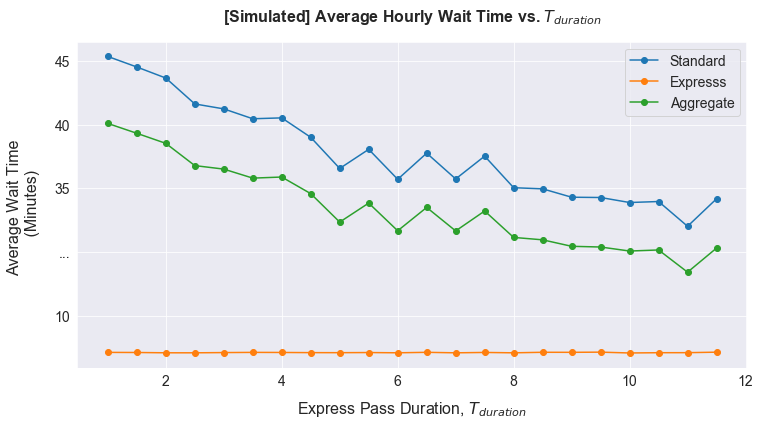

In [45]:
sns.set_style('darkgrid')
fig5atest, ax = plt.subplots(figsize = (12, 6))

plt.plot(df2_short.index, df2_short.iloc[:, 2], label = 'Standard', marker = 'o')
plt.plot(df2_short.index, df2_short.iloc[:, 1] + 20, label = 'Expresss', marker = 'o')
plt.plot(df2_short.index, df2_short.iloc[:, 0], label = 'Aggregate', marker = 'o')


plt.title('[Simulated] Average Hourly Wait Time vs. $T_{duration}$', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Express Pass Duration, $T_{duration}$', fontsize = 16, labelpad = 10)
plt.ylabel('Average Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
plt.yticks(np.arange(25, 50, 5), ['10', '...', '35', '40', '45'], fontsize = 14)
#plt.yticks(np.arange(27.5, 45.1, 2.5), ['10', '...', '20', '20', '30', '40', '50'], fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(prop={'size': 14})


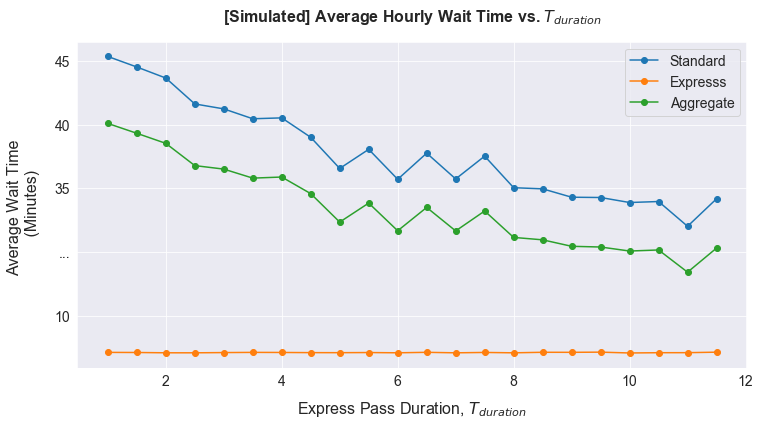

In [47]:
sns.set_style('darkgrid')
fig5a, ax5a = plt.subplots(figsize = (12, 6))

plt.plot(df2_short.index, df2_short.iloc[:, 2], label = 'Standard', marker = 'o')
plt.plot(df2_short.index, df2_short.iloc[:, 1] + 20, label = 'Expresss', marker = 'o')
plt.plot(df2_short.index, df2_short.iloc[:, 0], label = 'Aggregate', marker = 'o')


plt.title('[Simulated] Average Hourly Wait Time vs. $T_{duration}$', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Express Pass Duration, $T_{duration}$', fontsize = 16, labelpad = 10)
plt.ylabel('Average Wait Time \n (Minutes)', fontsize = 16, labelpad = 15)
plt.yticks(np.arange(25, 50, 5), ['10', '...', '35', '40', '45'], fontsize = 14)
#plt.yticks(np.arange(27.5, 45.1, 2.5), ['10', '...', '20', '20', '30', '40', '50'], fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(prop={'size': 14})
fig5a.savefig('fig5a.pdf')


In [21]:
## ONE DAY FUNCTION FOR MODEL #3 ##

##The cell contains a function to simulate a single day of the queueing system ##

def one_day_delay_duration(arrival_ls, delay, duration):
    
    ###  FOR TUNING  ###
    ExpressPriority = 1.0
    
    express_prop = 0.15
    express_abandon_prob = 0.15

    ####################
    
    customer_arrivals = [Customer(arr) for arr in arrival_ls]
    customer_arrivals = Customer_ls(customer_arrivals)

    NormalQueue, ExpressQueue, cust_output= Customer_ls(), Customer_ls(), Customer_ls()
    
    switched_11, switched_1 = False, False
    capacity_8, capacity_11, capacity_1 = 136, 170, 204
    train_capacity = capacity_8
    
    train_finish_time, prev_wait_time = 0, 0
    time = 0
    while len(customer_arrivals) > 0 or len(NormalQueue) > 0 or len(ExpressQueue) > 0:

        next_arr = customer_arrivals.next
        
        ## FIRST CAR DOESN"T LEAVE TILL FULL ##
        if train_finish_time == 0 and len(NormalQueue)<train_capacity:
            if np.random.binomial(n=1,p=express_prop):
                new_arrival = customer_arrivals.next_exits()
                new_arrival.arrival_time += np.random.uniform(delay,duration+delay)
                new_arrival.ctype = "express"
                customer_arrivals.add_to_nosort(new_arrival)
            else:
                new_arrival = customer_arrivals.next_exits()
                NormalQueue.add_to_nosort(new_arrival)
            
            if len(NormalQueue)==train_capacity:
                train_finish_time = NormalQueue.customer_ls[-1].arrival_time
        
        ## ARRIVAL TO SYSTEM ##
        elif len(customer_arrivals)>0 and (len(NormalQueue)+len(ExpressQueue)==0 or next_arr.arrival_time<train_finish_time):
            
            if next_arr.arrival_time>time:
                customer_arrivals.sort()
                time+=delay-0.05
                next_arr = customer_arrivals.next
            
            ## EXPRESS ARRIVAL
            if next_arr.ctype == "express":
                new_arrival = customer_arrivals.next_exits()
                ExpressQueue.add_to_nosort(new_arrival)
            
            ## NORMAL ARRIVAL ##
            elif next_arr.ctype == "normal":
                
                ## ACCEPT EXPRESS PASS ##
                shutoff_time = 11- delay
                if np.random.binomial(n=1,p=express_prop) and next_arr.arrival_time <= shutoff_time:
                    if next_arr.arrival_time <= 12 - (delay + duration):
                        new_arrival = customer_arrivals.next_exits()
                        new_arrival.arrival_time += np.random.uniform(delay, duration+delay)
                        new_arrival.ctype = "express"
                        customer_arrivals.add_to_nosort(new_arrival)                        
                    elif next_arr.arrival_time > 12 - (delay + duration):
                        new_arrival = customer_arrivals.next_exits()
                        new_arrival.arrival_time += np.random.uniform(delay,12-new_arrival.arrival_time)
                        new_arrival.ctype = "express"
                        customer_arrivals.add_to_nosort(new_arrival)
                
                ## ALWAYS STOP GIVING OUT EXPRESS PASSES AT 10.5 ##
                else:
                    new_arrival = customer_arrivals.next_exits()
                    NormalQueue.add_to_nosort(new_arrival)
                
        
        ## SEND A TRAIN ##
        else:
            if train_finish_time > 3 and not switched_11: 
                train_capacity = capacity_11
                switched_11 = True
            elif train_finish_time > 5 and not switched_1:
                train_capacity = capacity_1
                switched_1 = True
                
            train_max = min(train_capacity,len(NormalQueue)+len(ExpressQueue))
            rider_types = np.array([])
                
            train_count = 0
            last_abandon = False
            load_next = np.random.choice(['express','normal'],p=[ExpressPriority,1-ExpressPriority])
            while train_count < train_max:
                
                ## EXIT IF BOTH QUEUES ARE EMPTY ##
                if len(ExpressQueue)==0 and len(NormalQueue)==0:
                    train_max = train_count
                    
                ## PROCESS THE NEXT CUSTOMER FROM EITHER EXPRESS OR NORMAL ##
                else:
                    load_next = np.random.choice(['express','normal'],p=[ExpressPriority,1-ExpressPriority]) if not(last_abandon) else load_next
                    
                    ## NEXT IS EXPRESS ##
                    if len(ExpressQueue)!=0 and load_next=='express':
                        next_served = ExpressQueue.next_exits()
                        abandon_prob = express_abandon_prob
    
                    ## NEXT IS NORMAL ##
                    elif (len(ExpressQueue)==0 and len(NormalQueue)>0) or (len(NormalQueue)!=0 and load_next=='normal'):
                        next_served = NormalQueue.next_exits()
                        abandon_prob = next_served.abandon_prob(prev_wait_time)
                        
                    ## NO ABANDON ##
                    if np.random.binomial(n=1,p=1-abandon_prob):
                        new_wait_time = max(0,train_finish_time-next_served.arrival_time)
                        next_served.wait_time = new_wait_time
                        cust_output.add_to_nosort(next_served)
                        prev_wait_time = new_wait_time
                        train_count += 1
                        last_abandon=False
                        rider_types = np.append(rider_types, next_served.ctype)
                    
                    ## ABANDON ##
                    else:
                        next_served.wait_time = -999
                        cust_output.add_to_nosort(next_served)
                        last_abandon=True
            
            
            
            ## SPEED FACTOR AND SERVICE TIME ##
            proportion_express = 0 if len(rider_types)==0 else np.count_nonzero(rider_types == 'express') / len(rider_types)
            factor = speed_factor(proportion_express)
            
            load_min, load_max = 0.5/60, 1./60
            unload_min, unload_max = 0.25/60, 0.75/60
            
            load_time = factor * np.random.uniform(load_min, load_max)
            unload_time = np.random.uniform(unload_min, unload_max)
            service_time = load_time + 3./60 + unload_time
            
            train_finish_time = train_finish_time + service_time
    
    return cust_output

In [22]:
all_durations = []
all_delays = []
agg_avg, agg_max, norm_avg, norm_max, express_avg, express_max = [],[],[],[],[],[]

for delay in np.arange(0.5,3.01,0.5):
    durations = np.array([])
    duration = 1
    while duration + delay <= 12:
        
        # Simulating Trials 
        all_days, all_arrival_hours, all_arrivals, all_waits, all_custtypes = [],[],[],[],[]
        trials = 2
        for i in np.arange(1, trials + 1):
            arrival_ls = np.genfromtxt('data/day' + str(i) + '_arrivals.csv')[1:]
            customers = one_day_delay_duration(arrival_ls, delay, duration).customer_ls

            all_days = np.append(all_days, i*np.ones(len(customers))).astype(int)
            all_arrival_hours = np.append(all_arrival_hours, [int(customer.arrival_time) for customer in customers]).astype(int)
            all_arrivals = np.append(all_arrivals, [customer.arrival_time for customer in customers])
            all_waits = np.append(all_waits, [60*customer.wait_time for customer in customers])
            all_custtypes = np.append(all_custtypes, [customer.ctype for customer in customers])
        df_data = {'day':all_days,'arrival hour':all_arrival_hours,'arrival':all_arrivals,
                'wait':np.round(all_waits,3),'Customer Type':all_custtypes}
        df = pd.DataFrame(df_data)

        ## CLEANING OUT DATAFRAME ##
        df = df[df['wait'] >= 0]
        df = df.replace( {'normal' : 'Normal', 'express' : 'Express'})
        ## SEPARATE NORMAL & EXPRESS ##
        normal_df, express_df = df[df['Customer Type'] == 'Normal'], df[df['Customer Type'] == 'Express']

        agg_avg = np.append(agg_avg,np.round(np.mean(df['wait']),3))
        agg_max = np.append(agg_max,np.round(np.max(df['wait']),3))

        norm_avg = np.append(norm_avg,np.round(np.mean(normal_df['wait']),3))
        norm_max = np.append(norm_max,np.round(np.max(normal_df['wait']),3))

        express_avg = np.append(express_avg,np.round(np.mean(express_df['wait']),3))
        express_max = np.append(express_max,np.round(np.max(express_df['wait']),3))
        
        durations = np.append(durations,duration)
        duration += 1.0

    all_durations = np.append(all_durations,durations)
    delays = [delay] + (len(durations)-1)*[delay]

    all_delays = np.append(all_delays,delays)
    
    
    
df3_data = {
    'ExpressPass Delay': all_delays,
    'ExpressPass Duration':all_durations,
    'Aggregate Avg':agg_avg,
    'Express Avg':express_avg,
    'Normal Avg':norm_avg,
    'Aggregate Max':agg_max,
    'Express Max':express_avg,
    'Normal Max':norm_max
}
df3 = pd.DataFrame(df3_data).set_index('ExpressPass Delay')
df3


,ExpressPass Duration,Aggregate Avg,Express Avg,Normal Avg,Aggregate Max,Express Max,Normal Max
ExpressPass Delay,,,,,,,
0.5,1.0,39.984,2.127,45.301,64.845,2.127,64.845
0.5,2.0,38.939,2.118,44.107,63.731,2.118,63.731
0.5,3.0,36.871,2.095,41.674,61.395,2.095,61.395
0.5,4.0,36.707,2.098,41.560,61.678,2.098,61.678
0.5,5.0,33.057,2.092,37.260,53.941,2.092,53.941
0.5,6.0,32.190,2.085,36.397,54.426,2.085,54.426
0.5,7.0,32.508,2.114,36.810,55.110,2.114,55.110
0.5,8.0,31.889,2.091,35.936,56.539,2.091,56.539
0.5,9.0,30.425,2.090,34.333,55.169,2.090,55.169


In [180]:
df3_short = df3.iloc[:, [0, 3,2,1]]

In [122]:
df4 = df3_short.reset_index().iloc[:, [0,1,4]]
df4.head(3)

,ExpressPass Delay,ExpressPass Duration,Aggregate Avg
0,0.5,1.0,39.984
1,0.5,2.0,38.939
2,0.5,3.0,36.871


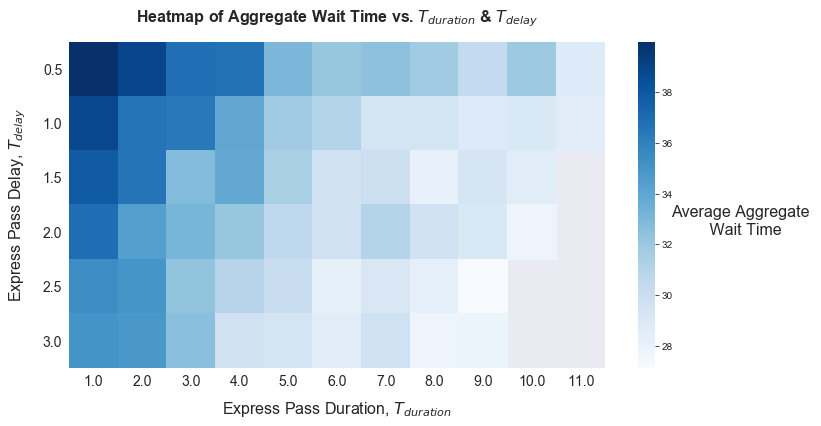

In [176]:
sns.set_style('darkgrid')
fig5b, ax5b = plt.subplots(figsize = (12, 6))

df5 = df4.pivot('ExpressPass Delay', 'ExpressPass Duration', 'Aggregate Avg')
sns.heatmap(data = df5, cmap = "Blues")
        
# cbar_kws={"orientation": "vertical", 'label' : 'Aggregate Wait Time', fontsize = 16})


plt.title('Heatmap of Aggregate Wait Time vs. $T_{duration}$ & $T_{delay}$', fontsize = 16, pad = 20, fontweight = 'semibold')
plt.xlabel('Express Pass Duration, $T_{duration}$', fontsize = 16, labelpad = 10)
plt.ylabel('Express Pass Delay, $T_{delay}$', fontsize = 16, labelpad = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14, rotation = 0)

ax5b.collections[0].colorbar.set_label("Average Aggregate \n Wait Time", fontsize = 16, 
                                       rotation = 0, labelpad = 70)
fig5b.savefig('fig5b.pdf')

